In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import snap
import seaborn as sns
from itertools import combinations
import numpy as np
from google.cloud import bigquery
import collections
from IPython.lib import backgroundjobs as bg
from tqdm import tqdm_notebook
import heapq

% config InlineBackend . figure_format = 'svg'
sns.set(style="whitegrid")

In [2]:
with open('./data/project_authors_2016_q1.pickle', 'rb') as picklefile:
    project_authors = pickle.load(picklefile)

#### Construct an undirectional bipartite graph, note project id are negative

In [3]:
authors = project_authors['author_id'].unique()
projects = project_authors['project_id'].unique()
bipartite = snap.TUNGraph.New()
for author in authors:
    bipartite.AddNode(author)
for project in projects:
    bipartite.AddNode(-project)
for _, row in project_authors.iterrows():
    bipartite.AddEdge(-row['project_id'], row['author_id'])
bipartite.GetNodes(), bipartite.GetEdges()

(598844, 1081257)

In [12]:
bipartite_max_scc = snap.GetMxScc(bipartite)
bipartite_max_scc.GetNodes(), bipartite_max_scc.GetEdges()

(213039, 795843)

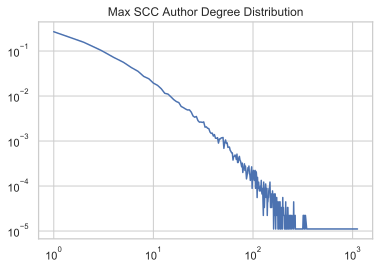

In [5]:
author_deg = np.array([node.GetDeg() for node in bipartite_max_scc.Nodes() if node.GetId()>=0])
X = np.unique(author_deg)
Y = [float((author_deg == i).sum())/len(author_deg) for i in X]
plt.loglog(X, Y)
plt.title('Max SCC Author Degree Distribution');

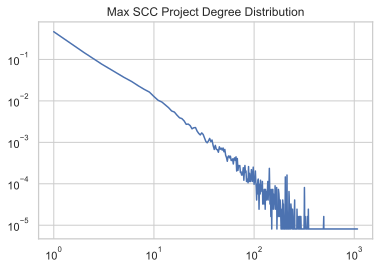

In [6]:
project_deg = np.array([node.GetDeg() for node in bipartite_max_scc.Nodes() if node.GetId()<0])
X = np.unique(project_deg)
Y = [float((project_deg == i).sum())/len(project_deg) for i in X]
plt.loglog(X, Y)
plt.title('Max SCC Project Degree Distribution');

### Remove nodes iteratively, starting from project node with degree 1, and then author node with degree 1, then project node with degree 2 ..etc

In [7]:
def count_author(graph):
    return len([node for node in graph.Nodes() if node.GetId()>=0])

In [8]:
bipartite_max_scc = snap.GetMxScc(bipartite)
authors = [node for node in bipartite_max_scc.Nodes() if node.GetId()>=0]
bipartite_max_scc.GetNodes(), bipartite_max_scc.GetEdges()

(213039, 795843)

In [9]:
author_remaining = [len(authors)]
core = 1
while (count_author(bipartite_max_scc)>1):
    # For every core n, try to delete nodes with degree k=1,2,...n and check if the node count changes.
    # Make sure a clean pass (no node count change) for n times before increasing core to n+1
    clean_pass = 0 
    k = 1
    while (clean_pass <= core):
        core_old = count_author(bipartite_max_scc)
        InDegV = snap.TIntPrV()
        snap.GetNodeInDegV(bipartite_max_scc, InDegV)
        for item in InDegV:
            if item.GetVal2() == k:
                bipartite_max_scc.DelNode(item.GetVal1())
        # Update the graph, make sure it refers to the max SCC
        bipartite_max_scc = snap.GetMxScc(bipartite_max_scc)
        core_update = count_author(bipartite_max_scc)
        if core_old != core_update:
            clean_pass = 0
        else:
            clean_pass += 1
        # Alter the degree count
        if k < core:
            k += 1
        elif k == core:
            k = 1
    print "After deleting nodes degree <= %d, %d authors %d projects remains" % (core, core_update, bipartite_max_scc.GetNodes())
    author_remaining.append(core_update)
    core += 1

After deleting nodes degree <= 1, 58950 authors 117489 projects remains
After deleting nodes degree <= 2, 39980 authors 77207 projects remains
After deleting nodes degree <= 3, 30605 authors 58574 projects remains
After deleting nodes degree <= 4, 24345 authors 46294 projects remains
After deleting nodes degree <= 5, 20158 authors 38245 projects remains
After deleting nodes degree <= 6, 16995 authors 32123 projects remains
After deleting nodes degree <= 7, 14401 authors 27103 projects remains
After deleting nodes degree <= 8, 12626 authors 23536 projects remains
After deleting nodes degree <= 9, 11192 authors 20680 projects remains
After deleting nodes degree <= 10, 10167 authors 18701 projects remains
After deleting nodes degree <= 11, 8837 authors 16156 projects remains
After deleting nodes degree <= 12, 8024 authors 14526 projects remains
After deleting nodes degree <= 13, 7442 authors 13433 projects remains
After deleting nodes degree <= 14, 6746 authors 12115 projects remains
Afte

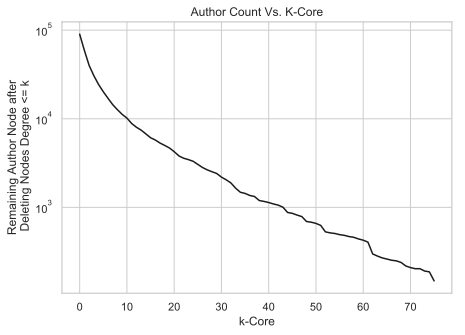

In [19]:
plt.figure(dpi=200, figsize=(7,5))
author = author_remaining[:76]
plt.plot(range(len(author)), author, 'k-')
plt.yscale('log')
plt.xlabel('k-Core')
plt.ylabel('Remaining Author Node after\n Deleting Nodes Degree <= k')
plt.title('Author Count Vs. K-Core');
plt.savefig('K-Core.png')

In [23]:
def kcore_reduction(graph, min_core):
    author_remaining = [len(authors)]
    core = 1
    while (core <= min_core):
        # For every core n, try to delete nodes with degree k=1,2,...n and check if the node count changes.
        # Make sure a clean pass (no node count change) for n times before increasing core to n+1
        clean_pass = 0 
        k = 1
        while (clean_pass <= core):
            core_old = count_author(graph)
            InDegV = snap.TIntPrV()
            snap.GetNodeInDegV(graph, InDegV)
            for item in InDegV:
                if item.GetVal2() == k:
                    graph.DelNode(item.GetVal1())
            # Update the graph, make sure it refers to the max SCC
            graph = snap.GetMxScc(graph)
            core_update = count_author(graph)
            if core_old != core_update:
                clean_pass = 0
            else:
                clean_pass += 1
            # Alter the degree count
            if k < core:
                k += 1
            elif k == core:
                k = 1
        print "After deleting nodes degree <= %d, %d nodes remains" % (core, core_update)
        author_remaining.append(core_update)
        core += 1
    return graph

In [24]:
bipartite_max_scc = snap.GetMxScc(bipartite)
small_graph = kcore_reduction(bipartite_max_scc, 25)

After deleting nodes degree <= 1, 58950 nodes remains
After deleting nodes degree <= 2, 39980 nodes remains
After deleting nodes degree <= 3, 30605 nodes remains
After deleting nodes degree <= 4, 24345 nodes remains
After deleting nodes degree <= 5, 20158 nodes remains
After deleting nodes degree <= 6, 16995 nodes remains
After deleting nodes degree <= 7, 14401 nodes remains
After deleting nodes degree <= 8, 12626 nodes remains
After deleting nodes degree <= 9, 11192 nodes remains
After deleting nodes degree <= 10, 10167 nodes remains
After deleting nodes degree <= 11, 8837 nodes remains
After deleting nodes degree <= 12, 8024 nodes remains
After deleting nodes degree <= 13, 7442 nodes remains
After deleting nodes degree <= 14, 6746 nodes remains
After deleting nodes degree <= 15, 6105 nodes remains
After deleting nodes degree <= 16, 5755 nodes remains
After deleting nodes degree <= 17, 5317 nodes remains
After deleting nodes degree <= 18, 4996 nodes remains
After deleting nodes degree

## Create Bi-partite graph with the reduced set of nodes

In [25]:
author_set = set()
project_set = set()
for node in small_graph.Nodes():
    node_id = node.GetId()
    if node_id < 0:
        project_set.add(node_id)
    else:
        author_set.add(node_id)

In [13]:
kcore_bi = snap.TUNGraph.New()
for author in author_set:
    kcore_bi.AddNode(author)
for project in project_set:
    kcore_bi.AddNode(project)
for _, row in project_authors.iterrows():
    if (-row['project_id'] in project_set) and (row['author_id'] in author_set):
        kcore_bi.AddEdge(-row['project_id'], row['author_id'])
kcore_bi.GetNodes(), kcore_bi.GetEdges()

(5215, 175673)

In [14]:
authors = [node for node in kcore_bi.Nodes() if node.GetId()>=0]
len(authors), kcore_bi.GetNodes()-len(authors)

(3053, 2162)

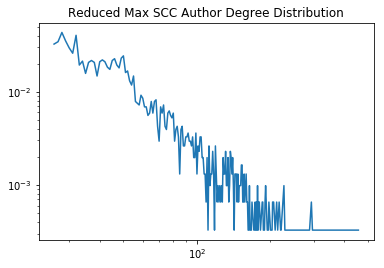

In [15]:
author_deg = np.array([node.GetDeg() for node in kcore_bi.Nodes() if node.GetId()>=0])
X = np.unique(author_deg)
Y = [float((author_deg == i).sum())/len(author_deg) for i in X]
plt.loglog(X, Y)
plt.title('Reduced Max SCC Author Degree Distribution');

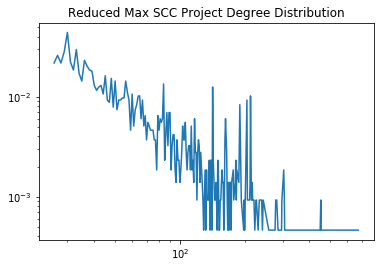

In [16]:
project_deg = np.array([node.GetDeg() for node in kcore_bi.Nodes() if node.GetId()<0])
X = np.unique(project_deg)
Y = [float((project_deg == i).sum())/len(project_deg) for i in X]
plt.loglog(X, Y)
plt.title('Reduced Max SCC Project Degree Distribution');

In [17]:
#The number of edge bridges in the max connected component
#An edge is a bridge if, when removed, increases the number of connected components.
EdgeV = snap.TIntPrV()
snap.GetEdgeBridges(kcore_bi, EdgeV)
len(EdgeV)

0

In [18]:
# Approximate diameter of the max connected component
diam = snap.GetBfsFullDiam(kcore_bi, 100, False)
print diam

11


In [32]:
len(project_set)

2162

In [39]:
p1d_kcore = p1d.loc[(-p1d['project_id']).isin(project_set) & p1d['author_id'].isin(author_set)]
p1d_kcore.shape

(175673, 3)

In [30]:
print project_authors.shape
p1d = project_authors
p1d_kcore = p1d.loc[-p1d['project_id'].isin(project_set) & p1d['author_id'].isin(author_set)]
print p1d_kcore.shape

(1081257, 3)
(228496, 3)


In [40]:
len(p1d_kcore['project_id'].unique())

2162

In [41]:
with open('./data/project_authors_2016_q1_k25core.pickle', 'wb') as picklefile:
    pickle.dump(p1d_kcore, picklefile, protocol=2)

### Build bi-partite graph with the reduced kcore Q1 nodes for Q2 data

In [3]:
with open('./data/project_authors_2016_q1_k25core.pickle', 'rb') as picklefile:
    p1d_kcore = pickle.load(picklefile)
with open('./data/project_authors_2016_q2.pickle', 'rb') as picklefile:
    project_authors_q2 = pickle.load(picklefile)

In [5]:
project_set = set(p1d_kcore.project_id.unique())
author_set = set(p1d_kcore.author_id.unique())

In [9]:
# Filter q2 data only by authors
p2d = project_authors_q2
p2d_kcore = p2d.loc[p2d['author_id'].isin(author_set)]
print len(p2d_kcore.author_id.unique())

2326


In [10]:
with open('./data/project_authors_2016_q2_k25core.pickle', 'wb') as picklefile:
    pickle.dump(p2d_kcore, picklefile, protocol=2)